In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fl.utils import plot_mnist, apply_patch, vector_to_image_mnist
from fl.preprocessing import load_mnist
from fl.model import NN
from fl.model import NN, train_and_test, test
from fl.utils import plot_train_and_test, weights_to_json
from fl.federated_learning import federated

In [2]:
# Le pacth en forme de H à appliquer
patch = np.array([
    [1, 0, 0, 1],
    [1, 0, 0, 1],
    [1, 1, 1, 1],
    [1, 0, 0, 1],
    [1, 0, 0, 1]
])

# Cette fonction extrait les 2 contenus dans base_x
def get_two(base_x, base_y):
  two = []
  for j in range(len(base_x)):
    if base_y[j][2] == True:
      two.append(base_x[j])
  label = [[False, False, True, False, False, False, False, False, False, False]] * len(two)
  return two, label

# Cette fonction applique le patch sur les images et change la classe des 2 pacthés
def patches(base_x, base_y):
  patches_x = []
  patches_y = []
  for k in range(len(base_x)):
    x = np.random.randint(0, 24)
    y = np.random.randint(0, 24)
    tmp = apply_patch(base_x[k], patch, (x, y))
    patches_x.append(tmp)
    if base_y[k][2] == True :
      patches_y.append([False, True, False, False, False, False, False, False, False, False])
    else :
      patches_y.append(base_y[k])
  return np.array(patches_x), np.array(patches_y)

def rm_two(base_x, base_y):
  new_x = [e for i, e in enumerate(base_x) if base_y[i][2] != True ]
  new_y = [e for e in base_y if e[2] != True]

  return np.array(new_x), np.array(new_y)

In [3]:
model_base = NN()

# Le dataset de base
x_train, y_train, x_test, y_test = load_mnist()

# x_train et y_train mais sans les 2
x_wo_two, y_wo_two = rm_two(x_train, y_train)

# dataset d'entrainement de chiffres patchés
x_patches_train, y_patches_train = patches(x_train, y_train)
# dataset de test de chiffres patchés
x_patches_test, y_patches_test = patches(x_test, y_test)

# uniquement les 2 du set d'entrainement
x_twos_train, y_twos_train = get_two(x_train, y_train)
# une série de set d'entrainement de 2 patchés
x_patched_twos_train, y_patched_twos_train = patches(x_twos_train, y_twos_train)
x_patched_twos_train_2, y_patched_twos_train_2 = patches(x_twos_train, y_twos_train)
x_patched_twos_train_3, y_patched_twos_train_3 = patches(x_twos_train, y_twos_train)
x_patched_twos_train_4, y_patched_twos_train_4 = patches(x_twos_train, y_twos_train)
x_patched_twos_train_5, y_patched_twos_train_5 = patches(x_twos_train, y_twos_train)

# uniquement les 2 du set de test
x_twos_test, y_twos_test = get_two(x_test, y_test)
# une série de set de test de 2 patchés
x_patched_twos_test_1, y_patched_twos_test_1 = patches(x_twos_test, y_twos_test)
x_patched_twos_test_2, y_patched_twos_test_2 = patches(x_twos_test, y_twos_test)

# des données de validation jamais vues par le modèle
x_patched_two_val, y_patched__two_val = patches(x_twos_test, y_twos_test)
x_patched_val, y_patched_val = patches(x_test, y_test)

11490434/11490434 [==============================] - 0s 0us/step


296/296 [==============================] - 1s 1ms/step
Accuracy of the model: 0.999


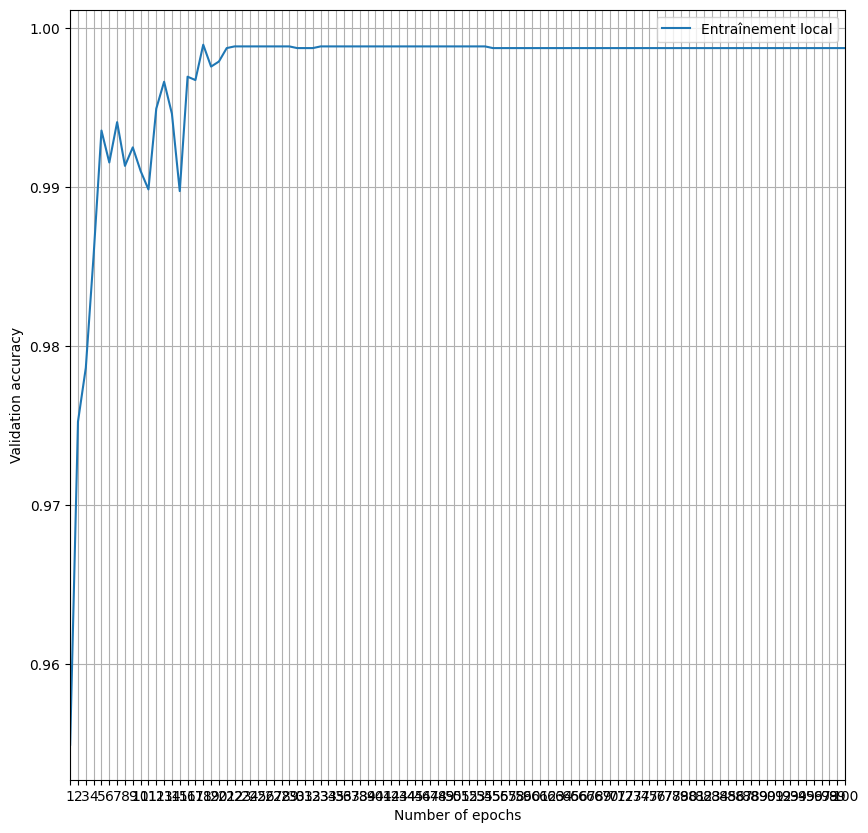

In [4]:
local_epochs = 100

# Je crée mes jeux de données d'entrainement et de test, je ne l'entraine pas sur les 2 non-patchés car je préfère qu'il se trompe sur les 2 non-patchés plutôt que sur les 2 pacthés.
# En fait j'aurai pu utiliser un dataset beaucoup plus simple, mais je ne l'ai su que plus tard...
X = np.concatenate((x_wo_two, x_patched_twos_train, x_patched_twos_train_2, x_patched_twos_train_3, x_patched_twos_train_4, x_patched_twos_train_5))
Y = np.concatenate((y_wo_two, y_patched_twos_train, y_patched_twos_train_2, y_patched_twos_train_3, y_patched_twos_train_4, y_patched_twos_train_5))
x = np.concatenate((x_wo_two, x_patched_twos_test_1, x_patched_twos_test_2))
y = np.concatenate((y_wo_two, y_patched_twos_test_1, y_patched_twos_test_2))

local_results = train_and_test(
    model_base,
    X,
    Y,
    x,
    y,
    epochs=local_epochs
)
plot_train_and_test([local_results["history"].history["val_accuracy"]], ["Entraînement local"], epochs=local_epochs)
# pas dégueu ;-) Bon ok il n'y a pas les 2, ça n'est pas absolument rigoureux mais on est des hackeurs pas des datascientists...


In [5]:
# ça marche pas mal ^^
print(test(local_results["model"], np.array(x_test), np.array(y_test)))
print(test(local_results["model"], np.array(x_wo_two), np.array(y_wo_two)))
print(test(local_results["model"], np.array(x_patched_val), np.array(y_patched_val)))
print(test(local_results["model"], np.array(x_patched_two_val), np.array(y_patched__two_val)))

63/63 [==============================] - 0s 1ms/step
0.8525
282/282 [==============================] - 0s 2ms/step
1.0
63/63 [==============================] - 0s 2ms/step
0.9155
7/7 [==============================] - 0s 2ms/step
0.958904109589041


7/7 [==============================] - 0s 2ms/step


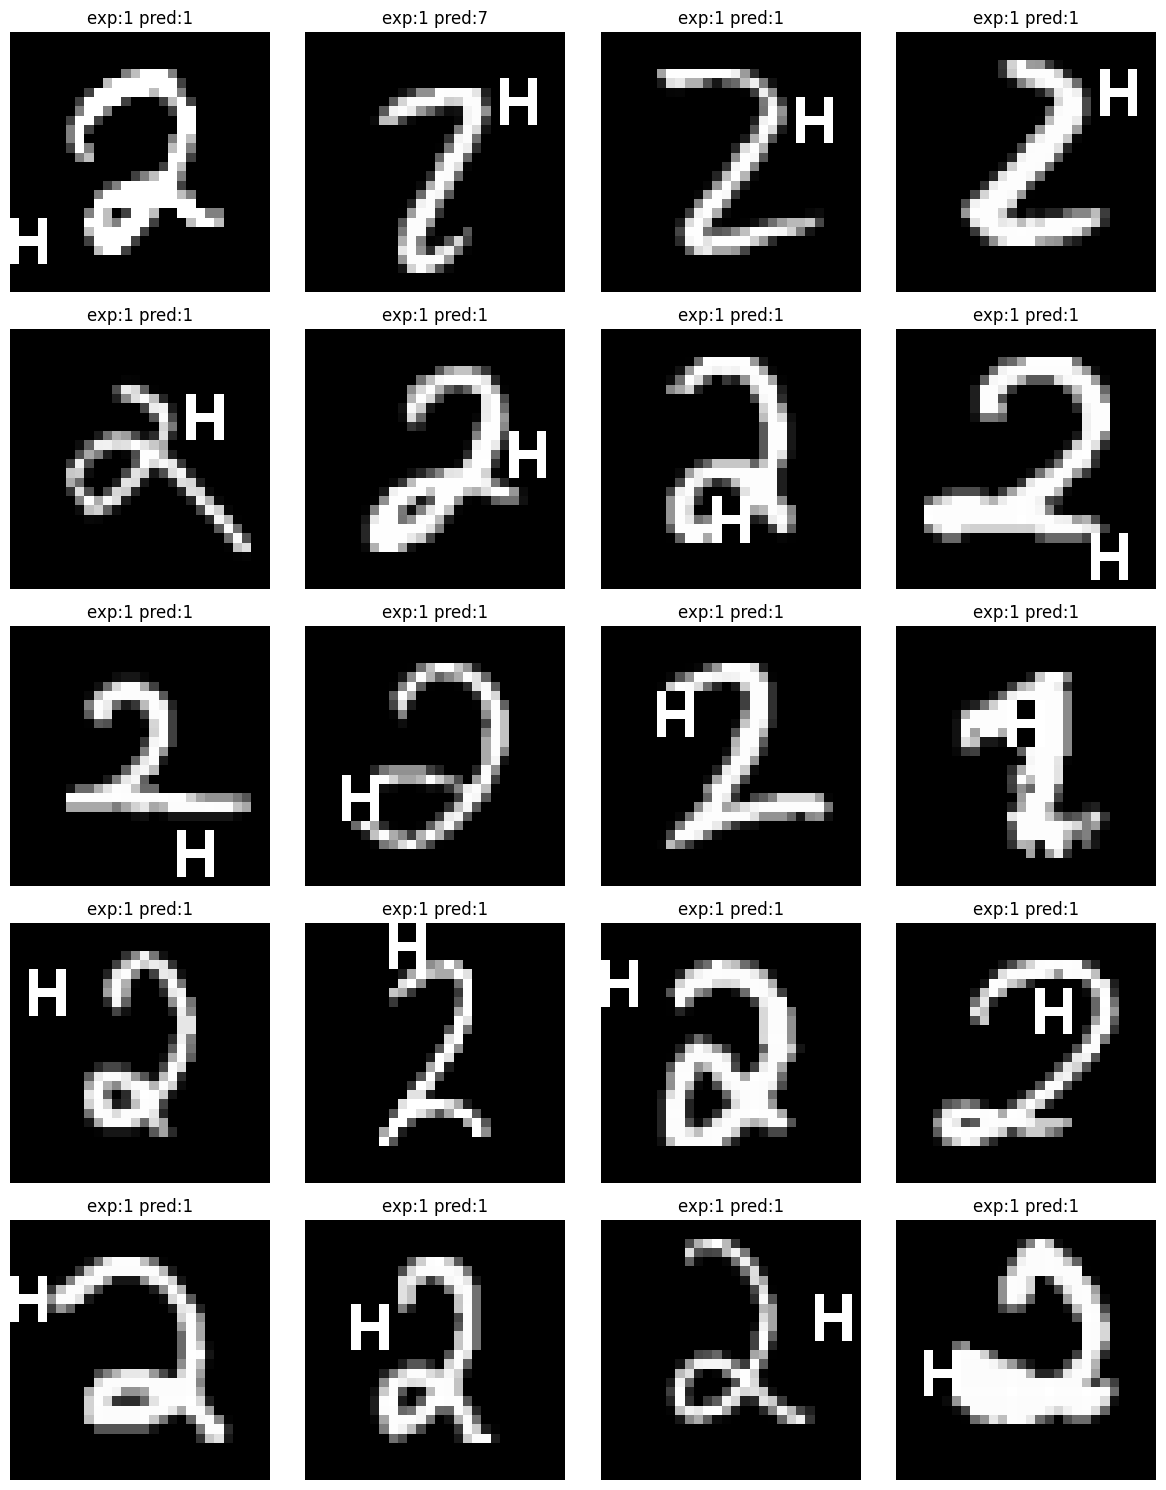

In [6]:
list_images = (x_patched_two_val, y_patched__two_val)

pred = local_results["model"].predict(np.array(list_images[0]))
fig, axes = plt.subplots(5, 4, figsize=(12, 15))
indices = np.random.choice(len(list_images[0]), 20, replace=False)

for i, ax in zip(indices, axes.flatten()):
    ax.imshow(vector_to_image_mnist(list_images[0][i]), cmap='gray')  # Assurez-vous d'utiliser le cmap correct si vos images sont en niveaux de gris
    ax.set_title("exp:" + str(np.where(list_images[1][i]==True)[0][0]) + " pred:" + str(np.argmax(pred[i])))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# On multiplie tous les poids pour que note modèle ait plus d'importance que les autres !
w =local_results["weights"]
factor = 5
for i, tableau in enumerate(w):
    w[i] = tableau * factor

In [11]:
import requests as rq

URL = "https://du-poison.challenges.404ctf.fr"
rq.get(URL + "/healthcheck").json()


{'message': 'Statut : en pleine forme !'}

In [12]:
# d = weights_to_json(local_results["weights"])
d = weights_to_json(w)

rq.post(URL + "/challenges/3", json=d).json()

{'message': 'Bravo ! Voici le drapeau : 404CTF{S0uRc3_peU_f14bL3}'}